In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)


Bad key "text.kerning_factor" on line 4 in
C:\Users\YH\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
train_err = pd.read_csv('train_err_data.csv')
test_err = pd.read_csv('test_err_data.csv')
train_test = pd.concat([train_err, test_err])
train_test['firmware'] = [i[:5] for i in train_test['fwver']]

datetime = np.array(train_test['time'])
new_datetime = []

for i in tqdm(range(len(datetime))):
    x = make_datetime(datetime[i])
    new_datetime.append(x)
    
new_datetime = np.array(new_datetime, dtype='datetime64')
train_test['time'] = new_datetime
# time 컬럼을 datetime 형으로 변환
train_test

100%|██████████████████████████████████████████████████████████████████| 33087311/33087311 [01:32<00:00, 359420.28it/s]


,user_id,time,model_nm,fwver,errtype,errcode,firmware
0,10000,2020-11-01 02:00:00,model_3,05.15.2138,15,1,05.15
1,10000,2020-11-01 03:00:00,model_3,05.15.2138,12,1,05.15
2,10000,2020-11-01 03:00:00,model_3,05.15.2138,11,1,05.15
3,10000,2020-11-01 05:00:00,model_3,05.15.2138,16,1,05.15
4,10000,2020-11-01 05:00:00,model_3,05.15.2138,4,0,05.15
...,...,...,...,...,...,...,...
16532643,44998,2020-11-30 21:00:00,model_1,04.16.3553,40,0,04.16
16532644,44998,2020-11-30 21:00:00,model_1,04.16.3553,31,1,04.16
16532645,44998,2020-11-30 21:00:00,model_1,04.16.3553,15,1,04.16
16532646,44998,2020-11-30 21:00:00,model_1,04.16.3553,16,1,04.16


# 1. fwver 에 집중한 분석

In [3]:
error = train_test.groupby('user_id')['time'].size()
df_error = pd.DataFrame(error, index=error.index)
df_error.columns = ['tot_err']
df_error # 각 유저별 총 에러 발생 횟수

,tot_err
user_id,
10000,317
10001,2365
10002,306
10003,306
10004,777
...,...
44994,1115
44995,515
44996,2233


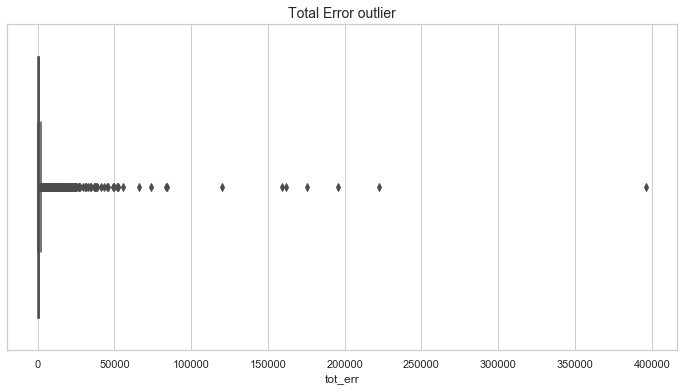

In [4]:
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,6))
plt.title('Total Error outlier', fontsize=14)
ax = sns.boxplot(x=df_error['tot_err'])

In [5]:
df_error['tot_err'].describe()

count     29998.000000
mean       1102.983899
std        3975.200829
min           1.000000
25%         402.000000
50%         657.000000
75%        1049.000000
max      396478.000000
Name: tot_err, dtype: float64

### 위의 Q3 값을 이상치의 기준으로 할 시
### 1049 회 이상 오류 발생시 이상치라고 판단

In [6]:
out_err = df_error[df_error['tot_err'] > 1049]
out_err # 이상치 유저들을 출력

,tot_err
user_id,
10001,2365
10009,1768
10010,7511
10013,4948
10014,2159
...,...
44989,1140
44992,6821
44994,1115


### 총 7493개의 이상치가 판단됨 
#### 이상치로 판단된 user 들의 특징을 추출해보자

In [7]:
out_id = list(out_err.index) # outlier들의 user_id

err_out = train_test[train_test['user_id'].isin(out_id)]
err_out # 이상치 user 들의 data

,user_id,time,model_nm,fwver,errtype,errcode,firmware
317,10001,2020-11-01 02:00:00,model_2,04.33.1185,15,1,04.33
318,10001,2020-11-01 02:00:00,model_2,04.33.1185,15,1,04.33
319,10001,2020-11-01 02:00:00,model_2,04.33.1185,31,1,04.33
320,10001,2020-11-01 02:00:00,model_2,04.33.1185,33,2,04.33
321,10001,2020-11-01 02:00:00,model_2,04.33.1185,12,1,04.33
...,...,...,...,...,...,...,...
16531770,44997,2020-11-30 22:00:00,model_0,04.22.1778,22,1,04.22
16531771,44997,2020-11-30 23:00:00,model_0,04.22.1778,23,active,04.22
16531772,44997,2020-11-30 23:00:00,model_0,04.22.1778,22,1,04.22
16531773,44997,2020-11-30 23:00:00,model_0,04.22.1778,23,active,04.22


### 이상치 user 들의 firmware 확인

In [8]:
out_fw = err_out.groupby(['user_id'])['firmware'].unique()
df_out_fw = pd.DataFrame(out_fw, index=out_fw.index)
df_out_fw.columns = ['firmware']
df_out_fw

,firmware
user_id,
10001,[04.33]
10009,[04.16]
10010,[04.16]
10013,[04.22]
10014,[04.33]
...,...
44989,[04.22]
44992,[04.22]
44994,[04.16]


### 각 firwmare 별 총 유저 수

In [9]:
out_fw2 = err_out.groupby(['firmware'])['user_id'].unique()
df_out_fw2 = pd.DataFrame(out_fw2, index=out_fw2.index)
df_out_fw2.columns = ['user_id']
df_out_fw2['total no.'] = [len(i) for i in df_out_fw2['user_id']]
df_out_fw2

,user_id,total no.
firmware,,
03.11,"[10092, 10167, 10217, 10263, 10265, 10298, 103...",503
04.16,"[10009, 10010, 10023, 10031, 10032, 10039, 100...",2986
04.22,"[10013, 10097, 10131, 10169, 10181, 10201, 102...",2099
04.33,"[10001, 10014, 10031, 10038, 10064, 10077, 100...",2369
04.73,"[10286, 10690, 11416, 12143, 21543, 23342, 237...",10
04.82,"[10408, 13896, 15674, 20311, 20970, 24346, 301...",15
05.15,"[10049, 10251, 10359, 10467, 10603, 10621, 106...",262
05.66,"[11149, 12047, 14496, 18237, 19251, 20650, 225...",11
10,[15680],1


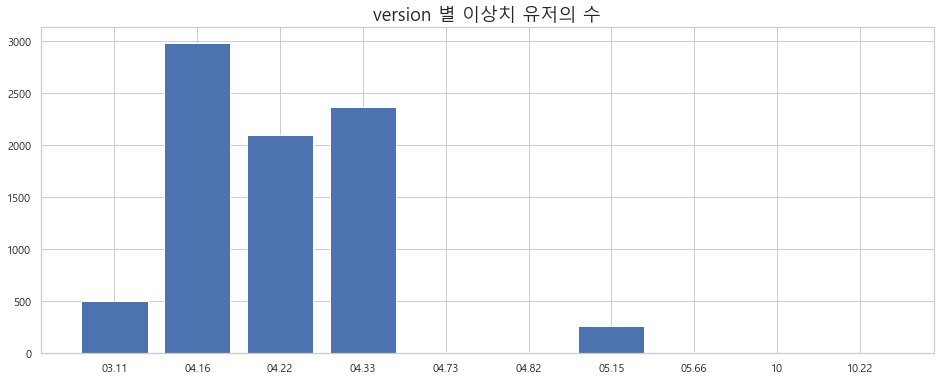

In [10]:
plt.rc('font', family='Malgun Gothic') 

plt.figure(figsize=(16,6))
plt.title('version 별 이상치 유저의 수', fontsize=18)
plt.bar(df_out_fw2.index, df_out_fw2['total no.'])
plt.show()

### 이상치 user 들의 펌웨어 버전을 시각화함
### 위의 결과로 보아 특정 firmware 버전에 이상치 유저가 많이 분포한다는 사실을 알 수 있다.
### => 04.16  04.22  04.33 버전이 특히 많음

# 2. model_nm 과 fwver 과의 관계

In [11]:
tot_mod_firm = train_test.groupby(['model_nm'])['firmware'].unique()
df_mod_firm = pd.DataFrame(tot_mod_firm, index=tot_mod_firm.index)
df_mod_firm

,firmware
model_nm,
model_0,"[04.22, 10.22]"
model_1,[04.16]
model_2,[04.33]
model_3,[05.15]
model_4,[03.11]
model_5,[04.82]
model_6,"[10, 8.5.3]"
model_7,[05.66]
model_8,[04.73]


### model_0,1,2,3,4 가 타 모델에 비해 많은 이상치 user를 포함한다고 볼 수 있다.

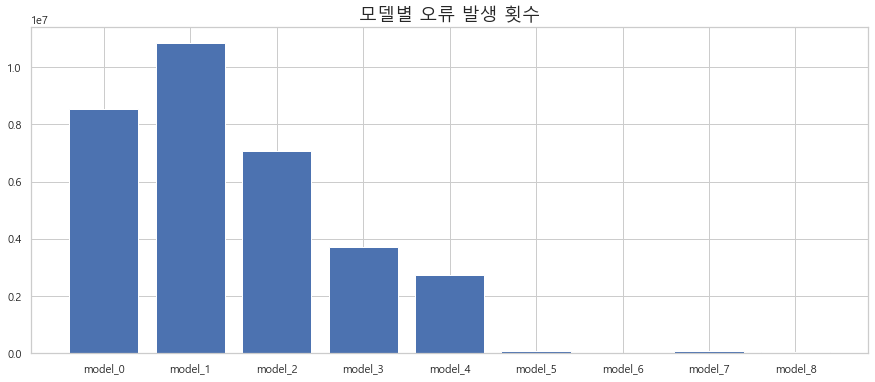

In [12]:
model_err = train_test.groupby(['model_nm'])['user_id'].size()

plt.figure(figsize=(15, 6))
plt.title('모델별 오류 발생 횟수', fontsize=18)
plt.bar(model_err.index, model_err)
plt.show()